In [1]:
import os
import PyPDF2
import re
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Ubicación de los archivos
path = './Tablas nutricionales en PDF'

In [3]:
# Para cada archivo, extraemos el texto del pdf
# tomamos del nombre del archivo el nombre de la comida,
# y guardamos los datos en un diccionario

tablas = {}
for f in os.listdir(path):
    pdf = PyPDF2.PdfFileReader(path + '/' + f)
    page = pdf.getPage(0)
    content = page.extractText()
    tablas[f.split('.')[0]] = content

In [4]:
# Usamos regular expressions para encontrar el primer número después 
# de cada categoría, y lo guardamos en un diccionario para cada comida.
# data es un diccionario de diccionarios, la primera llave es la comida
# y la segunda la categoría, ej. data['Chocolate']['Carbohidratos']

cat = [['Valor energético', 'energético'],
       ['Grasas totales', 'Grasas [tT]ota'],
       ['Grasas trans', 'Grasas trans'], 
       ['Grasas saturadas' ,'Grasas saturadas'],
       ['Carbohidratos', 'Carbohidratos'], 
       ['Proteínas', 'Prote[ií]nas'],
       ['Fibra alimentaria', 'Fibra alimentaria'],
       ['Sodio', 'Sodio']]

data = {}
for comida, tabla in tablas.items():
    temp = {}
    for c in cat:
        busqueda = re.search(f'{c[1]}[\s\S]*?([\d,]+)', tabla).group(1)
        temp[c[0]] = float(busqueda.replace(',','.'))
    data[comida] = temp

### Exploración

In [5]:
# Volcamos los datos en un DataFrame de Pandas

df = pd.DataFrame(data).T

In [6]:
# Vemos las primeras filas
df.head()

,Carbohidratos,Fibra alimentaria,Grasas saturadas,Grasas totales,Grasas trans,Proteínas,Sodio,Valor energético
Porcion de struesel,95.30,30.50,0.30,7.60,0.00,4.80,43.90,"1,801.24"
Empanadas de puerro y champignon,4.70,6.20,2.00,14.70,0.00,11.20,448.90,"1,127.45"
Semillas de chia,50.50,41.30,4.00,36.90,0.00,19.80,19.20,"2,437.78"
Pan cuatro cereales sin sal,340.60,117.10,1.00,23.80,0.00,239.00,627.10,"11,080.45"
Muffin con manzana,16.50,2.60,0.40,12.70,0.00,4.50,59.40,"1,025.96"


In [7]:
# Vemos algunas estadísticas descriptivas
df.describe()

,Carbohidratos,Fibra alimentaria,Grasas saturadas,Grasas totales,Grasas trans,Proteínas,Sodio,Valor energético
count,175.00,175.00,175.00,175.00,175.00,175.00,175.00,175.00
mean,127.83,22.73,2.79,30.96,0.01,33.22,981.98,"3,657.97"
std,314.97,28.66,4.96,30.73,0.11,45.68,"1,532.22","3,169.06"
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,256.28
25%,11.75,3.60,0.35,9.30,0.00,7.35,72.95,"1,076.18"
50%,51.10,9.50,1.10,19.60,0.00,15.10,306.70,"2,414.40"
75%,190.90,33.35,3.10,41.60,0.00,44.70,966.35,"6,045.33"
max,"3,840.00",134.70,32.40,144.60,1.44,262.40,"7,696.10","13,803.13"


### Visualización

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot, iplot

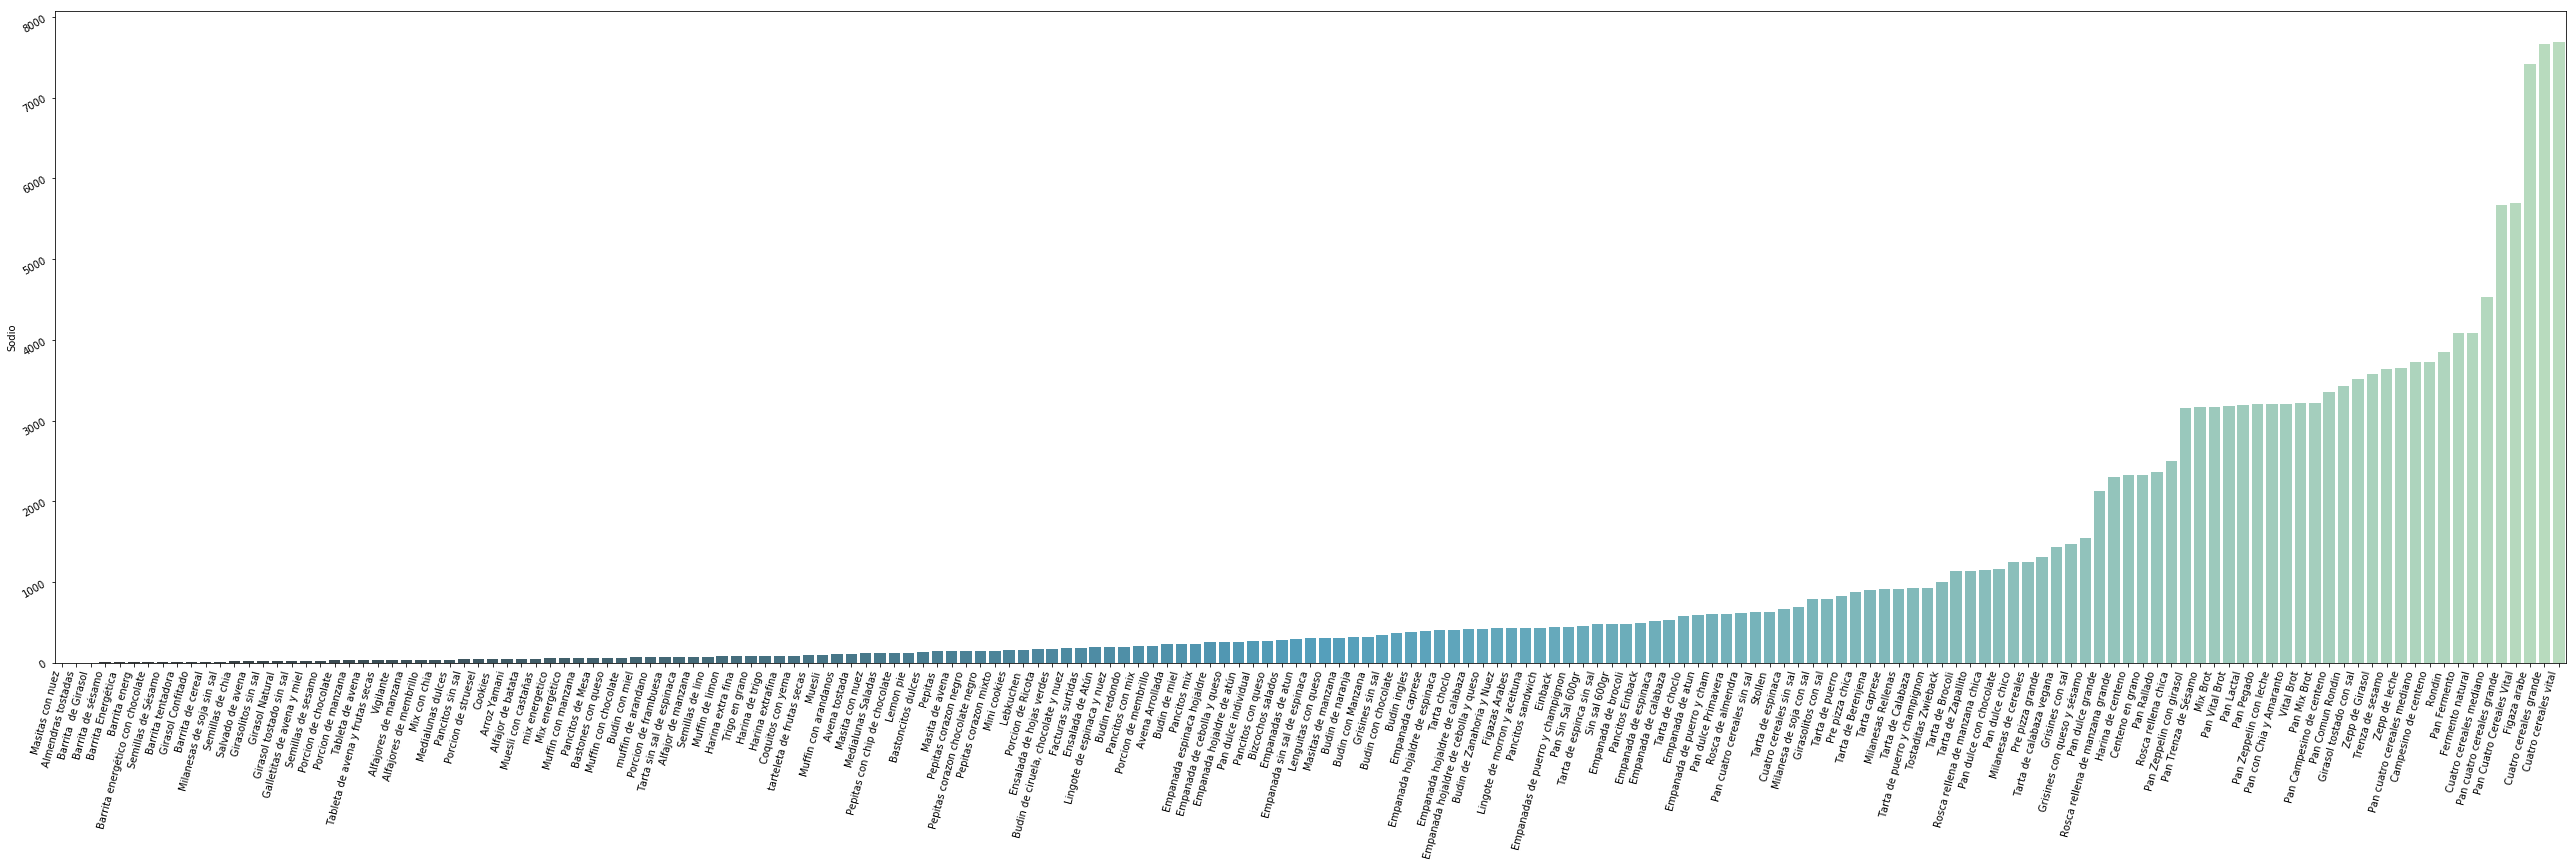

In [9]:
# Eligiendo una columna, graficamos los valores para todas las comidas con Seaborn

column = 'Sodio'

df.sort_values(column, inplace=True)

plt.figure(figsize=(45,12))
sns.barplot(x=df.index, y =column,data=df, palette='GnBu_d')

plt.yticks(rotation=30);
plt.xticks(rotation=75, ha='right');

In [10]:
columns = ['Carbohidratos', 'Grasas totales']

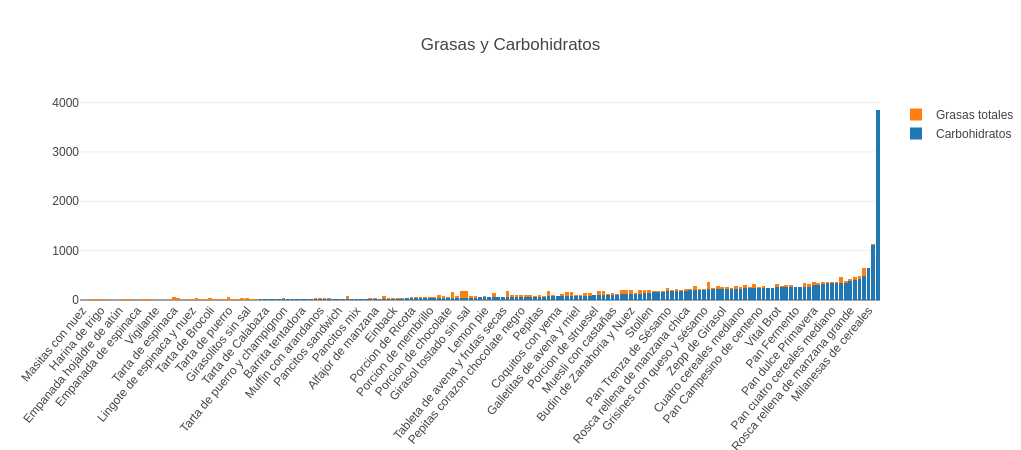

In [11]:
df.sort_values(by=columns, inplace=True)

data = [go.Bar(
        x=df.index, # assign x as the dataframe column 'x'
        y=df[columns[0]], 
        name=columns[0]
    ),

        go.Bar(
        x=df.index, # assign x as the dataframe column 'x'
        y=df[columns[1]],
        name=columns[1]
    )
]

layout = go.Layout(
    barmode='stack',
    title='Grasas y Carbohidratos',
    xaxis=dict(tickangle=-50, 
               tickfont=dict(size=12)),
    margin=go.layout.Margin(
        l=80,
        r=0,
        b=150,
        t=100,
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='./grasasycarb')

### Modelado

- Usamos sci-kit learn para encontrar clusters de comidas, quedandonos con la mejor cantidad de clusters según los puntajes Silhouette y Calinski-Harabaz. 
- Para graficar en 2 o 3 dimensiones, aplicamos una reducción de dimensionalidad no lineal (TSNE). 

In [12]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabaz_score

In [13]:
# Ajustamos el modelo TSNE para 3 dimensiones

tsne = TSNE(n_components=3)
proj = tsne.fit_transform(df)

In [14]:
# Probamos con distintas cantidades de clusters
# y calculamos su Silhouette

n_clusters = [2,3,4,5,6]
for n in n_clusters:
    clus = KMeans(n_clusters=n, random_state=0)
    clusters = clus.fit_predict(proj)
    
    silhouette_avg = silhouette_score(proj, clusters)
    cal_har = calinski_harabaz_score(proj, clusters)
    print(f"Para {n} clusters los puntajes son: "
         f"\nSilhouette {silhouette_avg:.2f}\nCalinski-Harabaz {cal_har:.2f}")

Para 2 clusters los puntajes son: 
Silhouette 0.29
Calinski-Harabaz 85.13
Para 3 clusters los puntajes son: 
Silhouette 0.29
Calinski-Harabaz 81.36
Para 4 clusters los puntajes son: 
Silhouette 0.28
Calinski-Harabaz 78.70
Para 5 clusters los puntajes son: 
Silhouette 0.28
Calinski-Harabaz 76.59
Para 6 clusters los puntajes son: 
Silhouette 0.28
Calinski-Harabaz 75.35


In [15]:
# Nos quedamos con 4 clusters y ajustamos los grupos usando K-Means
clus = KMeans(n_clusters=4, random_state=0)
clusters = clus.fit_predict(proj)

In [16]:
# Asignamos las dimensiones del TSNE como x,y,z
x,y,z = proj[:, 0], proj[:, 1], proj[:, 2]

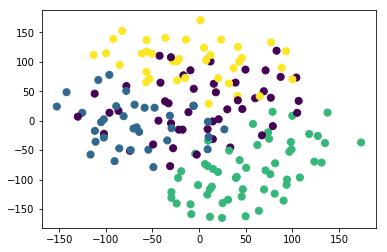

In [19]:
plt.scatter(x, y, c=clusters, s=50, cmap='viridis');

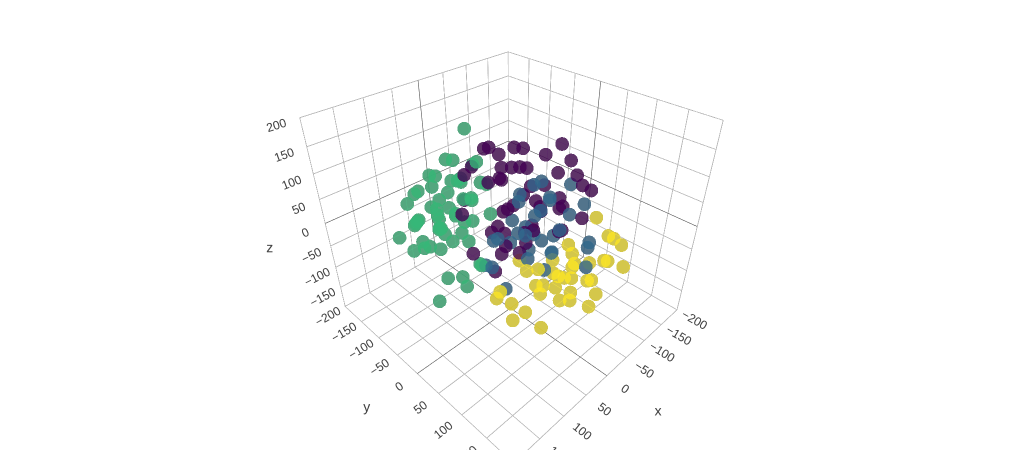

In [18]:
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    hovertext = df.index,
    marker=dict(
        size=8,
        color=clusters,         
        colorscale='Viridis',
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(autosize=True,
    title = 'Te amo',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
scene = dict(
                xaxis = dict(range = [-200,200]),
                yaxis = dict(range = [-200,200]),
                zaxis = dict(range = [-200,200]),
              ),
paper_bgcolor='rgba(0,0,0,0)',
plot_bgcolor='rgba(0,0,0,0)',
)
                   
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='./scatter3D')